In [286]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [287]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [288]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [289]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [290]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [291]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 20)
test_df:  (50, 20)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_train,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_train,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

# Load Data

In [292]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE < "2007-09-30"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 20)
test_df:  (50, 20)


In [293]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [294]:
#case = 1  # Taylor Rule
#case = 2  # Modified Taylor Rule drop AR term
#case = 3  # Modified Taylor Rule
case = 4  # Modified Taylor Rule
#case = 5  # Modified Taylor Rule drop inflation
#case = 6  # Modified Taylor Rule drop inflation
#case = 7  # Modified Taylor Rule drop inflation
#case = 8  # Modified Taylor Rule drop inflation
#case = None  # Extened Taylor Rule

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_gdp']]
    y_train = train_df['FEDFUNDS']

    X_test = test_df[['gap_inf', 'gap_gdp',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_gdp']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 2:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 3:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 4:
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
                       
                       
elif case == 5:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 6:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 7:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 8:
    print('-- Modified Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
else:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

-- Full Model (Lasso Base)


In [295]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (200, 5)


# LGBM

In [296]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.6011823662282061 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [297]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler_num',
                                                                   PowerTransformer()),
                                                                  ('imp_num',
                                                                   SimpleImputer())]),
                                                  ['FEDFUNDS-1', 'gap_inf',
                                                   'gap_gdp', 'gap_ue']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.020404898976033085, max_depth=4,
                               min_data_in_leaf=10, n_estimators=260,
                               num_leaves=49, reg_alpha=0.07714526452120027,
                               verbose=-1))])

In [298]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [299]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

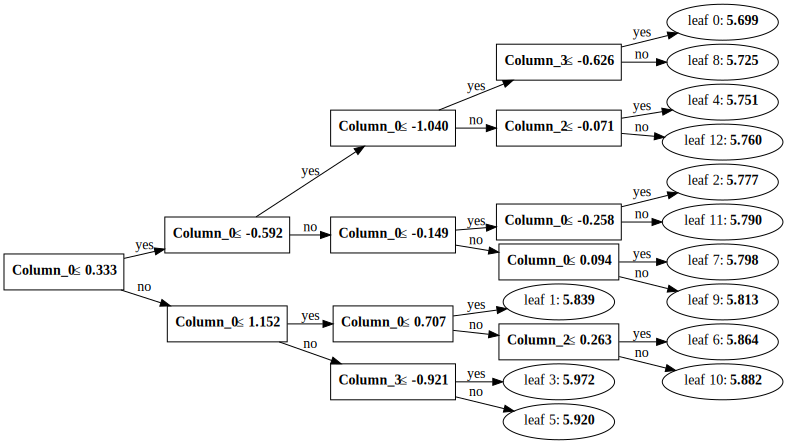

In [300]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [301]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
0,num__FEDFUNDS-1,1006
2,num__gap_gdp,496
1,num__gap_inf,311
3,num__gap_ue,253
4,cat__onehotencoder__recession_flag_True,65


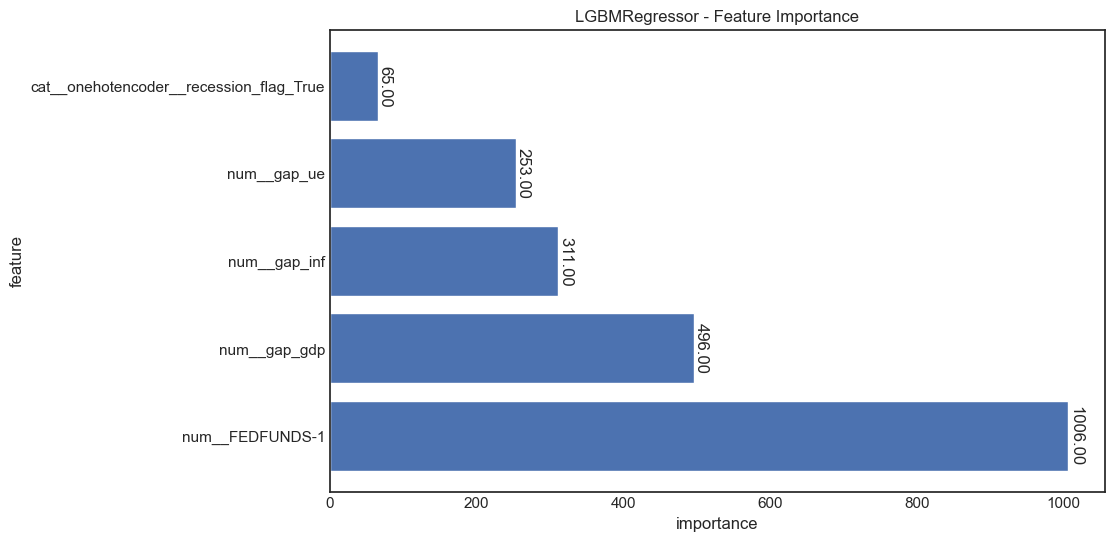

In [302]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

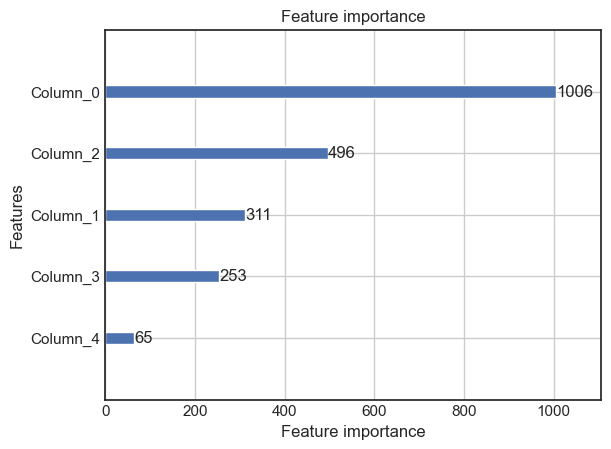

In [303]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [304]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [305]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(50,)

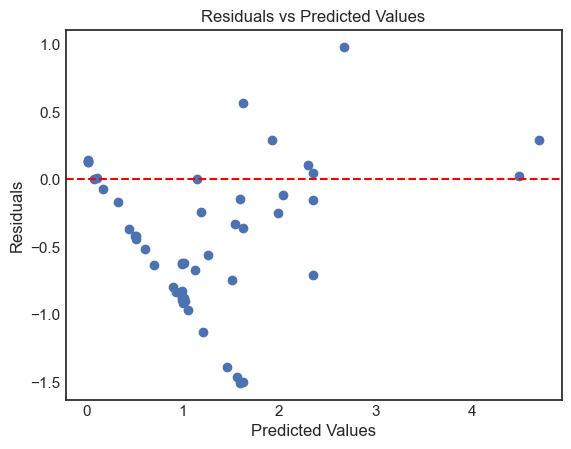

In [306]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [307]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

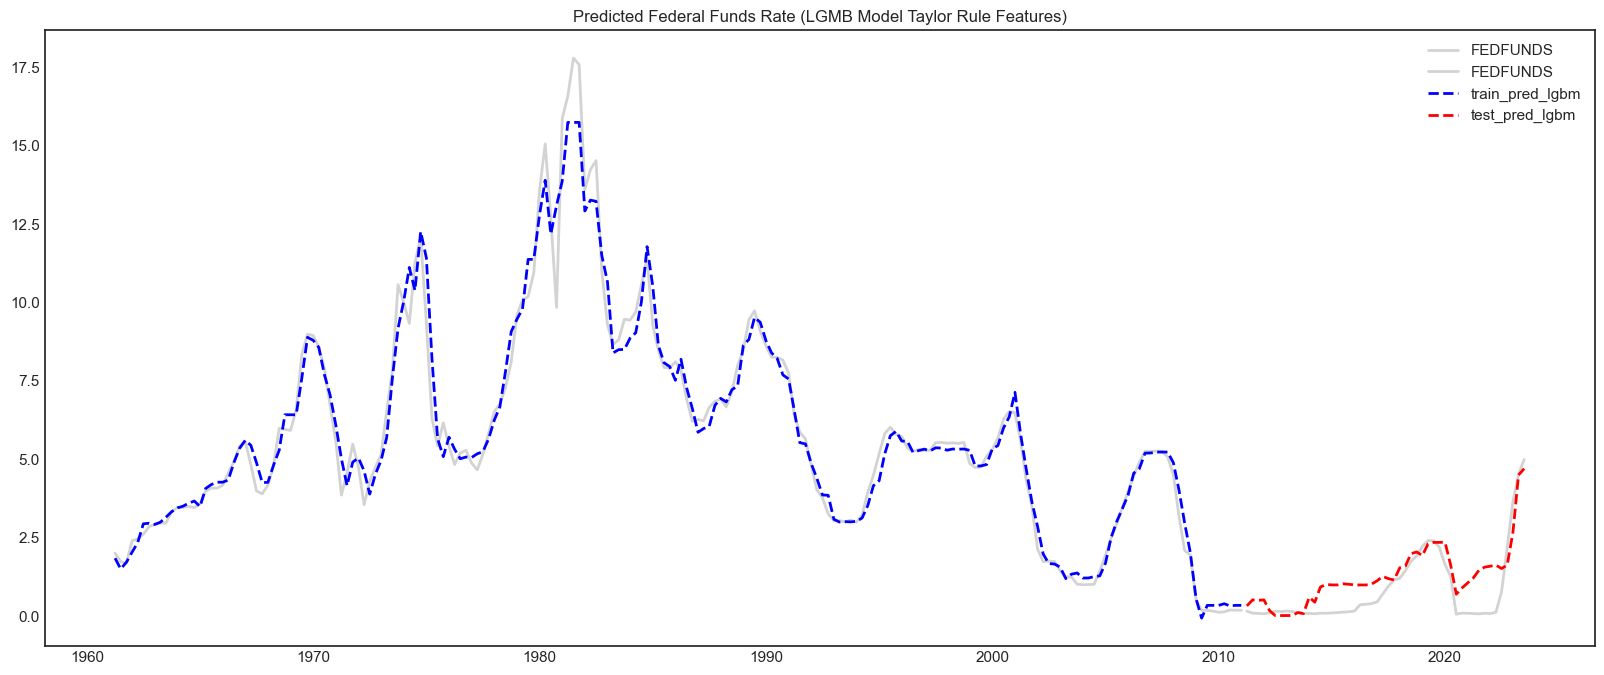

In [308]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

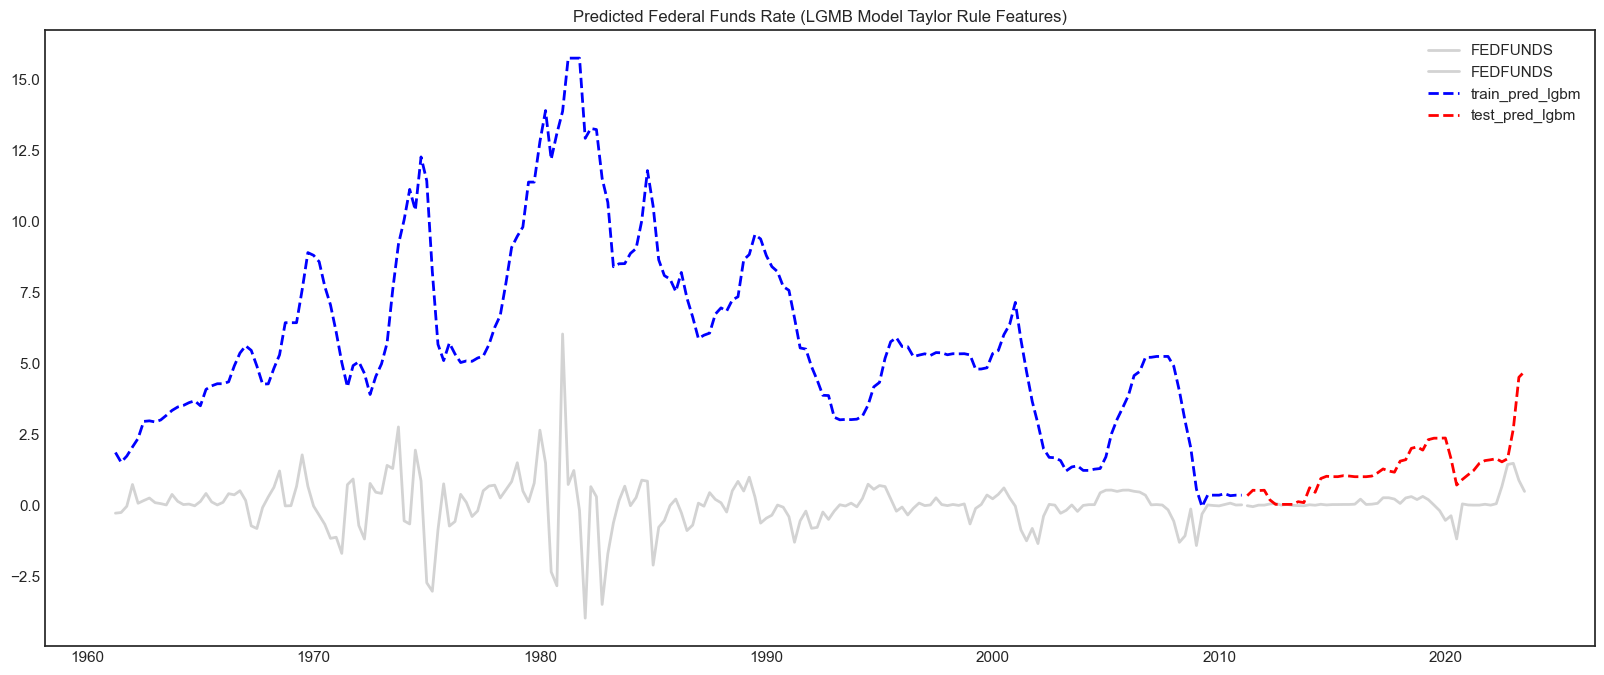

In [309]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# XGB

In [310]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.43644001348788863 Parameters: {} {'model__colsample_bytree': 0.976741035115452, 'model__learning_rate': 0.14428788990749752, 'model__max_depth': 6, 'model__min_child_weight': 5, 'model__n_estimators': 199, 'model__reg_alpha': 0.052405244655099874, 'model__subsample': 0.513148869727346, 'model__verbose': -1}


In [311]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9987846697819971

In [312]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.976741035115452, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.14428788990749752, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=199, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [313]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [314]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [315]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler_num',
                                                                                                PowerTransformer()),
                                                                                               ('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['FEDFUNDS-1',
                                                                                'gap_inf',
                                                                                'gap_gdp',
                                                                                'gap_ue']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x167dcab90>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x167dca6e0>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1688b2dd0>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1688d57e0>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [316]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

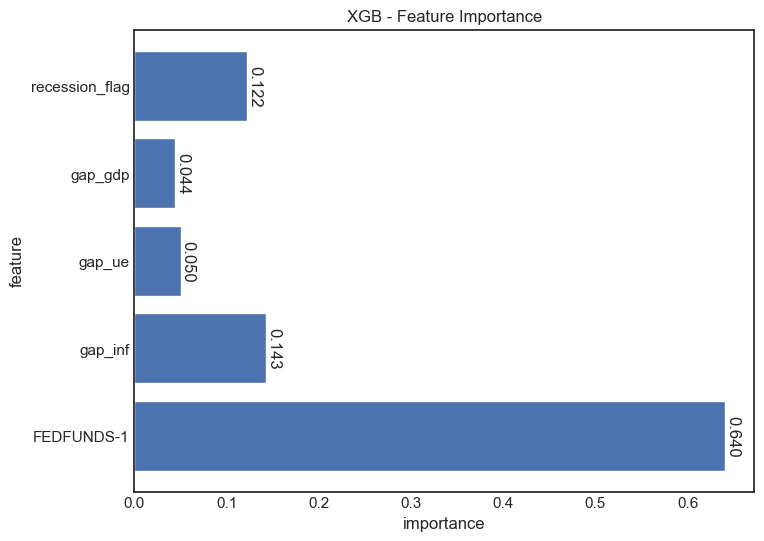

In [317]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

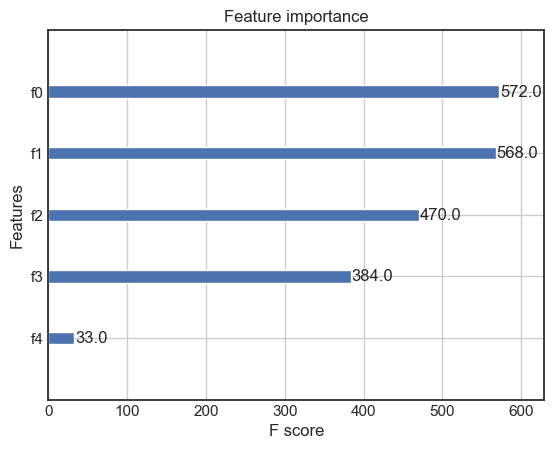

In [318]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [319]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [320]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (50,)


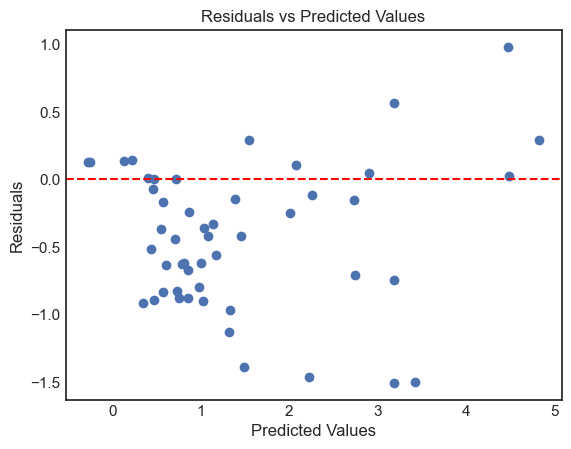

In [321]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [322]:
model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

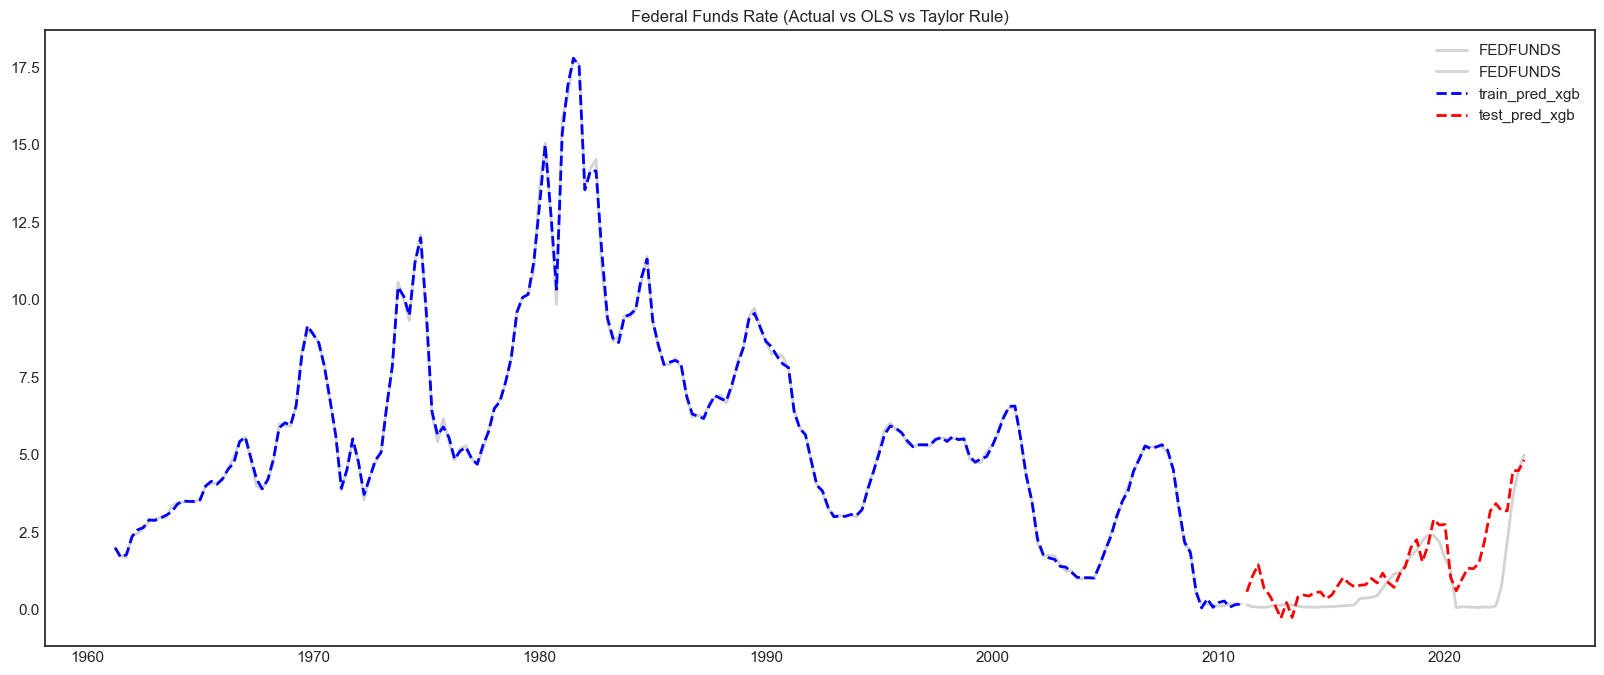

In [323]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

In [324]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_train,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_train,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,lgbm_train,0.9700,0.9693,0.3506,0.5921
7,lgbm_test,0.6606,0.6305,0.4644,0.6814
8,xgb_train,0.9988,0.9988,0.0142,0.1191
9,xgb_test,0.6606,0.6305,0.4644,0.6814
